<a href="https://colab.research.google.com/github/BenoitProst/act102_actuariat-vie/blob/main/Exercice_mod%C3%A8le_de_Vasicek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Lien du Notebook vers commit Github](https://github.com/BenoitProst/act102_actuariat-vie/blob/9465b474717b19ab786cddc00c8ddd03456202c3/Exercice_mod%C3%A8le_de_Vasicek.ipynb)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

## On importe les données de l'Euribor 1 mois sur l'année 2023

In [3]:
chemin_fichier = "/content/drive/MyDrive/Développement compétences/CNAM Master 1 actuariat/ACT102 - Actuariat Vie/Exercice modèle de Vasicek/Euribor 2023 1 mois.csv"

In [4]:
df = pd.read_csv(chemin_fichier, sep=',')

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [6]:
df['1 week'] = df['1 week'].str.replace(',', '.').astype(float)
df['1 month'] = df['1 month'].str.replace(',', '.').astype(float)
df['3 month'] = df['3 month'].str.replace(',', '.').astype(float)
df['6 month'] = df['6 month'].str.replace(',', '.').astype(float)
df['12 month'] = df['12 month'].str.replace(',', '.').astype(float)

In [7]:
df.dtypes

Date        datetime64[ns]
1 week             float64
1 month            float64
3 month            float64
6 month            float64
12 month           float64
dtype: object

In [8]:
df

,Date,1 week,1 month,3 month,6 month,12 month
0,2023-01-02,1.876,1.883,2.162,2.732,3.316
1,2023-01-03,1.838,1.854,2.172,2.739,3.321
2,2023-01-04,1.882,1.888,2.170,2.761,3.312
3,2023-01-05,1.878,1.894,2.178,2.772,3.303
4,2023-01-06,1.890,1.904,2.254,2.805,3.328
...,...,...,...,...,...,...
250,2023-12-21,3.852,3.876,3.916,3.899,3.582
251,2023-12-22,3.872,3.865,3.931,3.895,3.581
252,2023-12-27,3.857,3.843,3.925,3.885,3.554
253,2023-12-28,3.883,3.872,3.893,3.877,3.536


## Mettons les données réelles sous forme de graphique

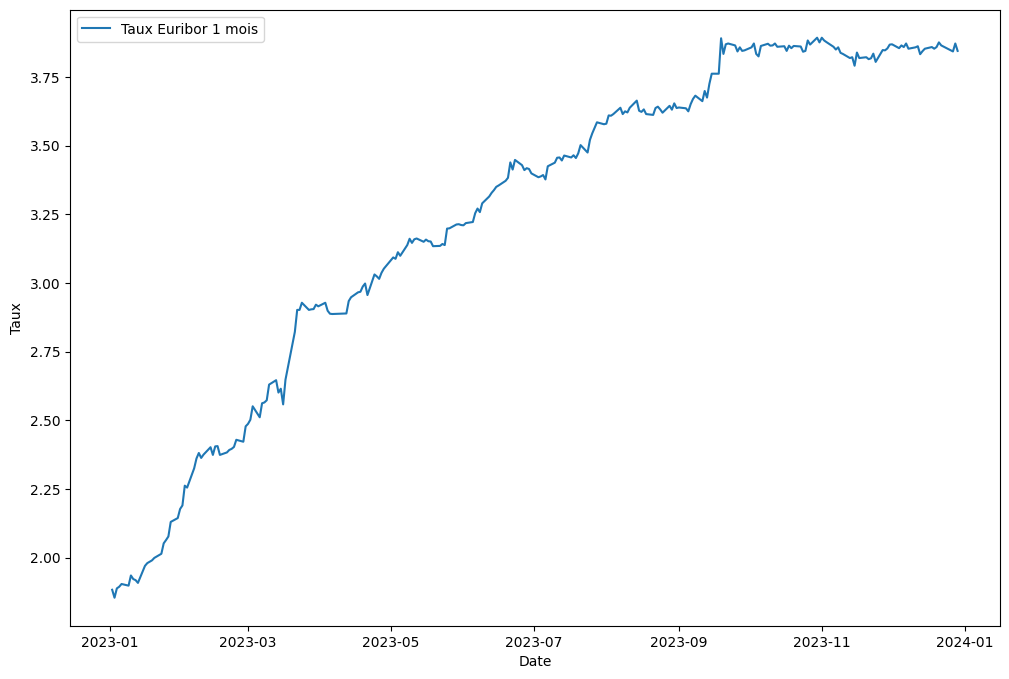

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(df['Date'], df['1 month'], label='Taux Euribor 1 mois')
ax.set_xlabel("Date")
ax.set_ylabel("Taux")
ax.legend()

## Estimons les paramètres du modèle de Vasicek avec la méthode des moindres carrés

Rappel de l'équation différentielle stochastique du modèle de vasicek

$$
dr_t = a(b - r_t) \, dt + \sigma \, dW_t
$$

On le met sous forme discret
$$
r_{t+\Delta t} = r_t + a(b - r_t)\cdot \Delta t + \sigma \sqrt{\Delta t} \cdot \epsilon
$$

et on l'écrit sous forme linéaire
$$
r_{t+\Delta t} = (1 - a \cdot \Delta t) \cdot r_t + a \cdot b \cdot  \Delta t + \sigma \sqrt{\Delta t} \cdot \epsilon
$$

In [12]:
#Calcul de notre pas de temps (dt). Comme nous sommes sur une année, il est égal à un divisé par le nombre de jours de cotation
# soit le nombre de lignes de notre dataframe
dt = 1/len(df)

In [13]:
# Création des 2 listes de taux avec décalage

r0 = df['1 month'][:-1].values.reshape(-1, 1)  # Toutes les valeurs sauf la dernière
r1 = df['1 month'][1:].values.reshape(-1, 1)   # Toutes les valeurs sauf la première

In [14]:
def Vasicek_LS(r0, r1, dt):

  #Régression linéaire
  reg = LinearRegression().fit(r0, r1)

  #Estimation a et b
  a_LS = (1 - reg.coef_) / dt
  b_LS = reg.intercept_ / dt / a_LS

  #Estimation du sigma
  epsilon = r1 - r0 * reg.coef_
  sigma_LS = np.std(epsilon) / np.sqrt(dt)

  return a_LS[0], b_LS[0], sigma_LS

In [15]:
print("l'alpha a est %.2f" % Vasicek_LS(r0, r1, dt)[0][0])
print("le beta b est %.2f" % Vasicek_LS(r0, r1, dt)[1][0])
print("le sigma est %.2f" % Vasicek_LS(r0, r1, dt)[2])

l'alpha a est 2.28
le beta b est 4.11
le sigma est 0.40


## Simulons l'euribor 1 mois avec les paramètres du modèle de Vasicek estimés

In [16]:
def Vasicek(r00, a, b, sigma, T, N):

  rates = [r00]
  for i in range(N):
    dr = a*(b-rates[-1])*dt + \
    sigma* \
    np.sqrt(dt)*np.random.normal()
    rates.append(rates[-1] +dr)
  return range(N+1), rates

In [17]:
# Taux au 1er janvier 2023
r00 = df['1 month'][0]

# Paramètres estimés
a = Vasicek_LS(r0, r1, dt)[0][0]
b = Vasicek_LS(r0, r1, dt)[1][0]
sigma = Vasicek_LS(r0, r1, dt)[2]

# Une année et nombres de pas - 1 pour être calé avec les données historiques
T = 1
N = len(df) - 1

In [18]:
# Rajout des données simulées au dataframe
df['1 month modèle Vasicek'] = Vasicek(r00, a, b, sigma, T, N)[1]

In [19]:
df

,Date,1 week,1 month,3 month,6 month,12 month,1 month modèle Vasicek
0,2023-01-02,1.876,1.883,2.162,2.732,3.316,1.883000
1,2023-01-03,1.838,1.854,2.172,2.739,3.321,1.928027
2,2023-01-04,1.882,1.888,2.170,2.761,3.312,1.897100
3,2023-01-05,1.878,1.894,2.178,2.772,3.303,1.914061
4,2023-01-06,1.890,1.904,2.254,2.805,3.328,1.942177
...,...,...,...,...,...,...,...
250,2023-12-21,3.852,3.876,3.916,3.899,3.582,3.951005
251,2023-12-22,3.872,3.865,3.931,3.895,3.581,3.989383
252,2023-12-27,3.857,3.843,3.925,3.885,3.554,3.999984
253,2023-12-28,3.883,3.872,3.893,3.877,3.536,4.011209


## Création du graphique pour comparer les données historiques avec une simulation

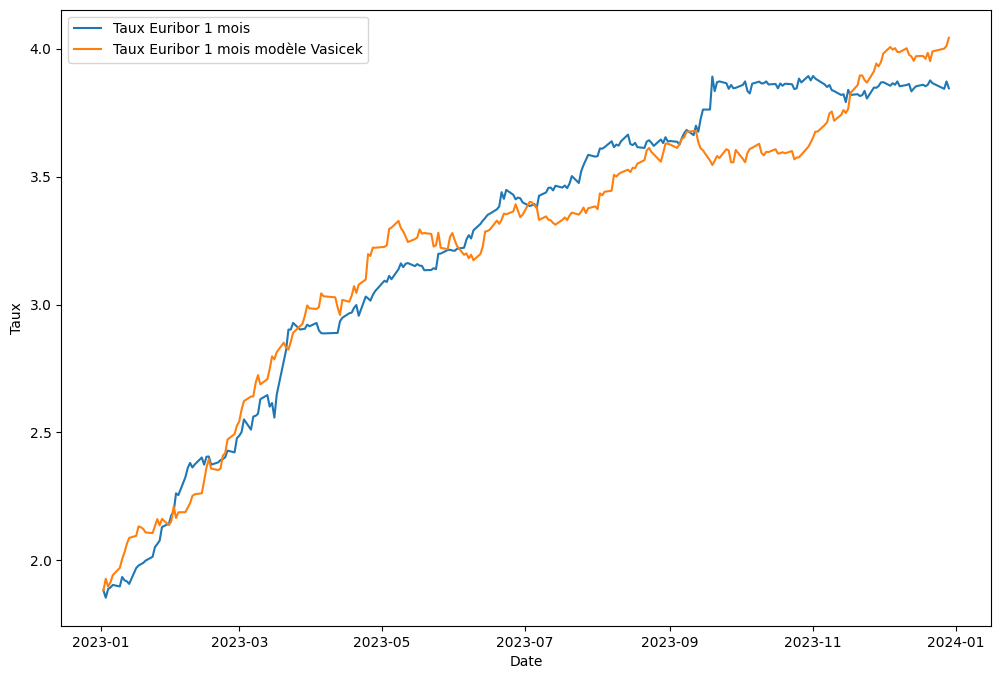

In [20]:


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(df['Date'], df['1 month'], label='Taux Euribor 1 mois')
ax.plot(df['Date'], df['1 month modèle Vasicek'], label='Taux Euribor 1 mois modèle Vasicek')
ax.set_xlabel("Date")
ax.set_ylabel("Taux")
ax.legend()